In [1]:
!pip install git+https://github.com/davidhoof/quality-match-homework.git --log /content/log.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/davidhoof/quality-match-homework.git to /tmp/pip-req-build-s_vvaqgm
  Running command git clone -q https://github.com/davidhoof/quality-match-homework.git /tmp/pip-req-build-s_vvaqgm


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import itertools
import random
from imageio import imread
import math

from analysis.parser.project_parser import ProjectParser
from analysis.parser.references_parser import ReferenceParser
from analysis.image.input_display import InputDisplay

reference_dataset_path = '/content/references.json'
project_dataset_path = '/content/anonymized_project.json'

In [3]:
def extract_disagreement_questions(df, disagreement_range=(0.5,0.5)):
  """
  Extract the disagreement on all inputs given in the dataframe.
  :param df pandas dataframe to extract from
  :param disagreement_range range in which the disagreement is extracted
  :returns pandas Dataframe with the extracted disagreement
  """
  df_questions_normalized = df.groupby(by='project_node_input_id')['task_output.answer'].value_counts(normalize=True).to_frame().rename(columns={'task_output.answer':'task_output.normalized'})
  df_questions_normalized= df_questions_normalized[(df_questions_normalized['task_output.normalized']>=disagreement_range[0]) & (df_questions_normalized['task_output.normalized']<=disagreement_range[1])]
  return df_questions_normalized.reset_index()

def merge_axis_legends(ax, ax2):
  """
  Merge the legends of the given axis together
  :param ax Axis 1
  :param ax2 Axis 2
  :returns merged lines, labels of the matplotlib legend
  """
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()

  return lines + lines2, labels + labels2 

def map_legend_labels(ax, mapping):
  """
  Map the legend labels of the given axis to the given mapping
  :param ax axis to map on
  :param mapping mapping to map legend labels on
  :return lines, labels of the matplotlib legend
  """
  lines, labels = ax.get_legend_handles_labels()    
  return lines, list(map(lambda x: mapping[x],(labels)))

def plot_disagreement(df, samples, label, **kwargs):
  """
  Function to plot the disagreement on the given samples
  :param Dataframe on which the disagreement data is extracted
  :param samples list of input ids to be plotted
  :param label Label for empty answers
  :param kwargs parameters to configure the matplot 
  :returns matplotlib fig
  """
  df_questions = extract_disagreement_questions(df[df['project_node_input_id'].isin(samples)],disagreement_range=(0,1))
  df_questions['task_output.answer']=df_questions['task_output.answer'].replace('','None')
  ax=df_questions.set_index(['project_node_input_id','task_output.answer']).unstack().plot.bar(stacked=True, **kwargs)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=315, ha='left')
  ax.grid(axis='y')

  label_mapping = {
      '(task_output.normalized, no)': 'No - Answers',
      '(task_output.normalized, yes)': 'Yes - Answers',
      '(task_output.normalized, None)': f'{label} - Flagged'
    }
  ax.legend(*map_legend_labels(ax,label_mapping), loc=0)
  ax.set_xlabel('Input IDs')
  ax.set_ylabel('Percentage of Questions normalized')
  return ax.get_figure()

def get_reference(img_name):
  """
  Get the reference value on the given image name
  :param img_name name of the image
  :returns reference on given name
  """
  return df_ref[df_ref['img_name']==img_name]['is_bicycle'].values[0]
def convert_answer_to_bool(answer):
  """
  Convert the answers to boolean value
  :param answer answer to be converted
  :return boolean value or NaN
  """
  if answer == 'no':
    return False
  elif answer == 'yes':
    return True
  else:
    return pd.NA

def extract_name_from_url(url: str):
  """
  Extract the image name from an given url
  :param url Url to be extracted from
  :return image name as str
  """
  return url.split('/')[-1].split('.')[0]

## Initialisation of the datasets
In this work pandas and matplotlib will be used for the statistics and visualizations.

In [4]:
referencesparser = ReferenceParser(reference_dataset_path)
df_ref = referencesparser.to_dataframe()
df_ref.head()

,img_name,is_bicycle
0,img_0000,False
1,img_0001,False
2,img_0002,False
3,img_0003,False
4,img_0004,True


In [5]:
projectparser = ProjectParser(project_dataset_path)
df=projectparser.to_dataframe()
df.head()

,created_at,workpackage_total_size,loss,project_node_input_id,project_node_output_id,project_root_node_input_id,task_input.image_url,task_output.answer,task_output.cant_solve,task_output.corrupt_data,task_output.duration_ms,user.vendor_id,user.id,user.vendor_user_id,root_input.image_url
0,2021-02-25T14:08:11.319438+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,0000439a-96ac-4bd4-8753-a4baa229ecf2,7e8984b6-dff7-4015-865a-b721a2faf681,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,997,vendor_01,08af8775-a72c-4c59-b60f-9ce7df04fa92,annotator_12,https://qm-auto-annotator.s3.eu-central-1.amaz...
1,2021-02-25T13:14:39.411149+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,0488b469-7c5f-459a-bfcb-ed94957c09c2,7e8984b6-dff7-4015-865a-b721a2faf681,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,845,vendor_01,62f1cf90-71c9-45c5-990c-f9dc0aa6ea3d,annotator_11,https://qm-auto-annotator.s3.eu-central-1.amaz...
2,2021-02-25T15:19:57.889434+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,323902a9-3b41-4885-8796-4e393aa2e0a0,7e8984b6-dff7-4015-865a-b721a2faf681,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,1468,vendor_01,780c974e-6ce7-4f1d-9afe-56bf96753fca,annotator_22,https://qm-auto-annotator.s3.eu-central-1.amaz...
3,2021-02-26T03:56:18.770331+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,4222ac20-7aaa-4b07-bb2b-4423bf41eefe,7e8984b6-dff7-4015-865a-b721a2faf681,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,1062,vendor_01,94afdf79-917c-4904-bdaa-7a121f33b0ff,annotator_17,https://qm-auto-annotator.s3.eu-central-1.amaz...
4,2021-02-25T15:39:06.644705+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,42ba767f-5bd1-4e62-aff1-4e716fd23623,7e8984b6-dff7-4015-865a-b721a2faf681,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,879,vendor_01,37a6036c-a9ef-4fcb-b554-7058f00415db,annotator_02,https://qm-auto-annotator.s3.eu-central-1.amaz...


## Task 1

### a. How many annotators did contribute to the dataset?

In [6]:
df['user.vendor_user_id'].unique()

array(['annotator_12', 'annotator_11', 'annotator_22', 'annotator_17',
       'annotator_02', 'annotator_16', 'annotator_15', 'annotator_20',
       'annotator_06', 'annotator_05', 'annotator_03', 'annotator_07',
       'annotator_08', 'annotator_04', 'annotator_13', 'annotator_21',
       'annotator_09', 'annotator_18', 'annotator_10', 'annotator_01',
       'annotator_14', 'annotator_19'], dtype=object)

In [7]:
len(df['user.vendor_user_id'].unique())

22

Answer: 22 annotatots contributed to the dataset.

### b. What are the average, min and max annotation times (durations)?

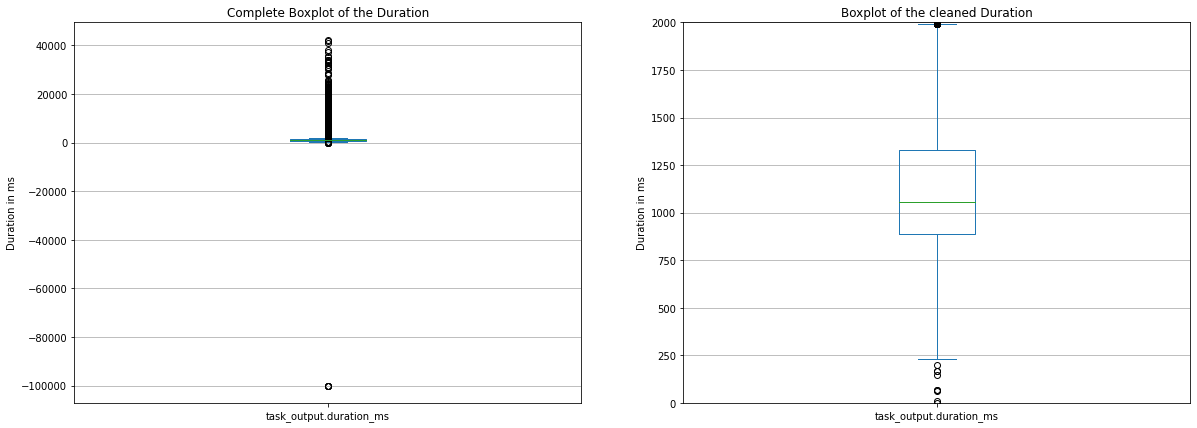

In [8]:
fig, ax = plt.subplots(1,2, figsize=(20,7))

df['task_output.duration_ms'].plot.box(ax=ax[0])

df[(df['task_output.duration_ms'] >=0)]['task_output.duration_ms'].plot.box(ax=ax[1], ylim=(0,2000))

ax[0].set_title("Complete Boxplot of the Duration")
ax[0].set_ylabel("Duration in ms")
ax[0].grid(axis='y')

ax[1].set_title("Boxplot of the cleaned Duration")
ax[1].set_ylabel("Duration in ms")
ax[1].grid(axis='y')

# fig.savefig('duration_boxplots.png')
fig.show()

The first Boxplot conists of all datapoints. Even the ones, which are -99999 and probably a measurement error. Statistics are shown below. The average of annotation times is 1284.33 ms. The max is at 42398 ms, which is ca. 42 seconds.
The min is at -99999, which, as just mentioned, probably represents a measurement error 

In [9]:
df['task_output.duration_ms'].describe()

count    90870.000000
mean      1284.333873
std       1351.960465
min     -99999.000000
25%        887.000000
50%       1058.000000
75%       1328.000000
max      42398.000000
Name: task_output.duration_ms, dtype: float64

The second boxplot conists of all datapoints except the negativ ones. Statistics are shown below. The average of the annotation times is at 1289.90, which is lightly higher, than in the previous plot. The min is at 0.0, which is most likely not a real value. 25% of the annotators are under 887 ms, which is really fast. The max value is the same at 42398 ms.

In [10]:
df[(df['task_output.duration_ms'] >=0)]['task_output.duration_ms'].describe()

count    90865.000000
mean      1289.907159
std       1124.001502
min          0.000000
25%        887.000000
50%       1058.000000
75%       1328.000000
max      42398.000000
Name: task_output.duration_ms, dtype: float64

### c. Did all annotators produce the same amount of results, or are there differences?

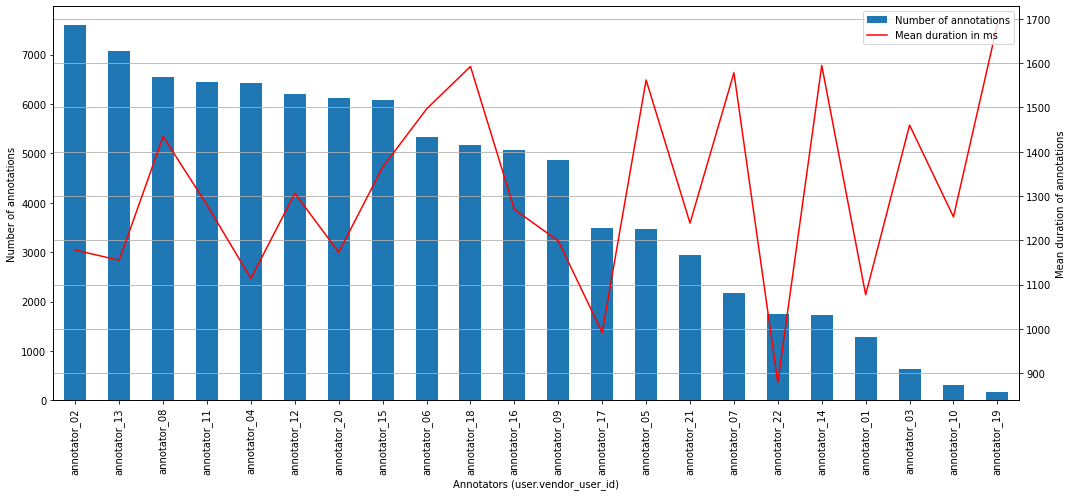

In [11]:
# fig, ax = plt.subplots(1,1, figsize=(15,7))
ax=df['user.vendor_user_id'].value_counts(sort=True).plot.bar(rot=90,figsize=(15,7))
annotators_sorted_list = df['user.vendor_user_id'].value_counts().index.tolist()
# print(ax.get_xlabel())
ax2=df[(df['task_output.duration_ms'] >=0)].groupby(by='user.vendor_user_id')['task_output.duration_ms'].mean().reindex(annotators_sorted_list).plot(ax=ax, rot=90, secondary_y=True,color='red')
ax2.grid(axis='y')
ax.set_ylabel("Number of annotations")
ax.set_xlabel("Annotators (user.vendor_user_id)")
ax2.set_ylabel("Mean duration of annotations")
ax2.legend()

label_mapping = {
    'task_output.duration_ms (right)' : 'Mean duration in ms',
    'user.vendor_user_id': 'Number of annotations'
}

ax2.legend(*zip(*map(lambda x, y: (x, label_mapping[y]), *merge_axis_legends(ax,ax2))), loc=1)

fig = ax2.get_figure()
fig.tight_layout()
# fig.savefig('numberofannotations_per_annotator.png')
fig.show()

In [12]:
corr=pd.concat(
    [
        df[(df['task_output.duration_ms'] >=0)].groupby(by='user.vendor_user_id')['task_output.duration_ms'].mean(),
        df['user.vendor_user_id'].value_counts(sort=True)
    ],
    axis=1
).rename(columns={'task_output.duration_ms':'Mean duration of annotations','user.vendor_user_id':'Number of annotations'}).corr()
corr.style.background_gradient(cmap='coolwarm')

,Mean duration of annotations,Number of annotations
Mean duration of annotations,1.000000,-0.193313
Number of annotations,-0.193313,1.000000


In [13]:
df['user.vendor_user_id'].value_counts(sort=True).describe()

count      22.000000
mean     4130.454545
std      2403.233550
min       170.000000
25%      1852.500000
50%      4960.500000
75%      6189.000000
max      7596.000000
Name: user.vendor_user_id, dtype: float64

As shown in the graph are the differences in the amount of produced results different between the annotators. On average, 4130 results were created by an single annotator. The lowest amount is contributed by annotator 19 with 170 results. Annotator 2 had the highest number of results with 7596 annotations.
A linear distribution of the annotation strength is clearly visible.

As an addition, the mean duration of an annotation is plotted as the red line to see an possible connection between these datapoints. No strong correlation can be seen between the number of annotations and the mean duration of an annotation. It becomes more evident in the correlation matrix above. With an very weak correlation of -0.193.

### d. Are there questions for which annotators highly disagree?

In [14]:
df['project_node_input_id'].unique().shape[0]

9087

In [15]:
df_questions = extract_disagreement_questions(df, disagreement_range=(0.5,0.5))
df_questions['project_node_input_id'].unique().shape[0]

68

Number of inputs with an disagreement between the annotators. 50 % of yes and 50% of no answers shows a high doubt between the annotators in 68 questions, which is a really small number in comparison with the total amount of 9087 questions.

In [16]:
df_questions = extract_disagreement_questions(df, disagreement_range=(0.4,0.6))
df_questions['project_node_input_id'].unique().shape[0]

197

A larger area can be used as a further study, e.g. with a difference of 40% to 60% in the questions to show, that more questions have a high disagreement inbetween them. 197 Questions are interpreted with a high disagreement, which is more than double than with exact 50%.

In the following are examples of images with a high disagreement in between the annotators. As can be seen, many of the images are very difficult to differentiate if the image contains a bicycle. Close Zoom in the image, coverups or only small pieces of bicycles are shown in the image, which are counterproductive for the annotation.

In [17]:
df_questions = extract_disagreement_questions(df, disagreement_range=(0.4,0.6))
disagreement_questions_input_ids=df_questions['project_node_input_id'].unique()
sample_size = 9
random_sample_input_ids=random.sample(list(disagreement_questions_input_ids),sample_size)

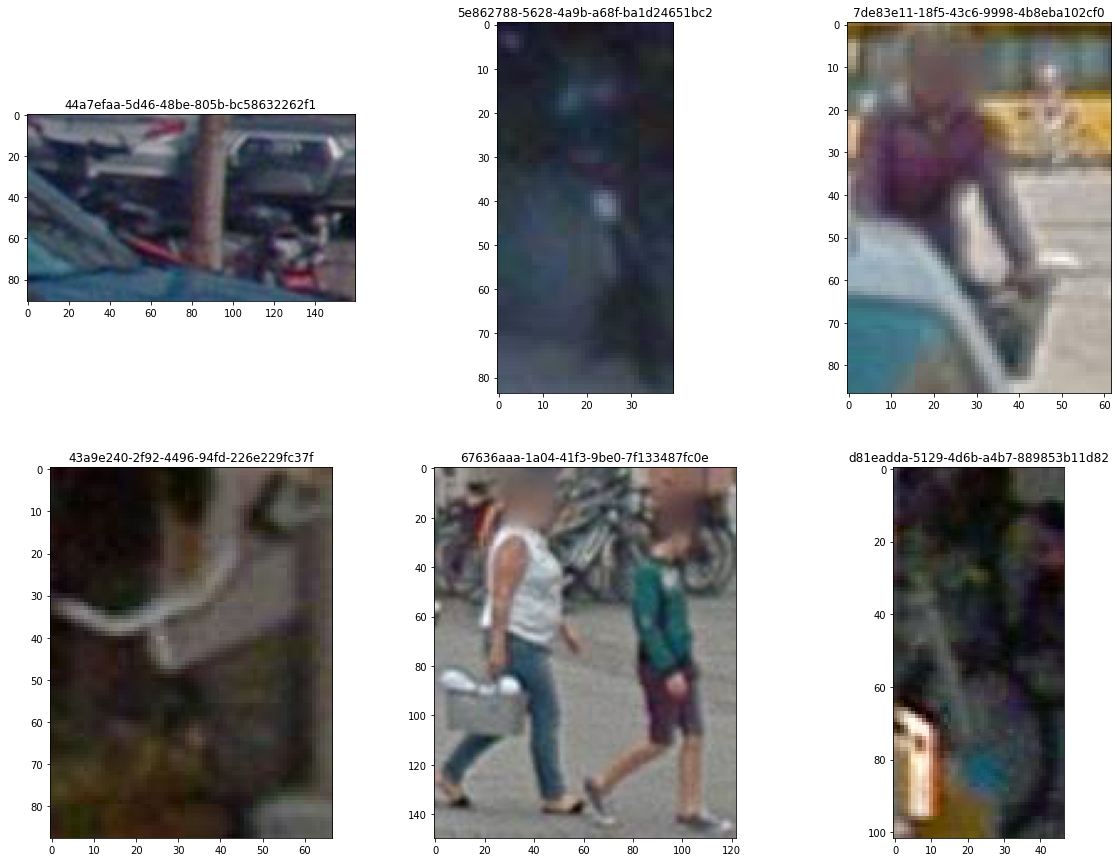

In [18]:
fig = InputDisplay(projectparser).plot_images(random_sample_input_ids, 2, 3, figsize=(20,15))
# fig.savefig('exampleimages_high_disagreement.png')
fig.show()

## Task 2
Besides picking yes or no the annotators had the chance to tell if the data were
corrupted or if they for any reason were not able to solve the task. These are fields
'cant_solve' and 'corrupt_data' given in the task_output.
### How often does each occur in the project and do you see a trend within the annotators that made use of these options?

In [19]:
df[(df['task_output.cant_solve'] == True)].shape[0]

17

In [20]:
df[(df['task_output.cant_solve'] == True)]['user.vendor_user_id'].unique()

array(['annotator_18', 'annotator_22', 'annotator_11', 'annotator_07',
       'annotator_04', 'annotator_08', 'annotator_14', 'annotator_02',
       'annotator_20'], dtype=object)

In [21]:
df[(df['task_output.corrupt_data'] == True)].shape[0]

4

In [22]:
df[(df['task_output.corrupt_data'] == True)]['user.vendor_user_id'].unique()

array(['annotator_18', 'annotator_06', 'annotator_08'], dtype=object)

The usage of the cant_solve or corrupt_data options is very small. 17 Inputs are marked as "cant solve" and only 4 Inputs are marked as "corrupted data". Not all of the annotators have used these options. As shown above nine annotators have used the cant_solve option and only 3 annotators have used the corrupted_data option. Annotator 18 and Annotator 8 have used both options independently.

To get a better unterstanding of the flagged images examples are shown below.

Images flagged with "Cant_solve"

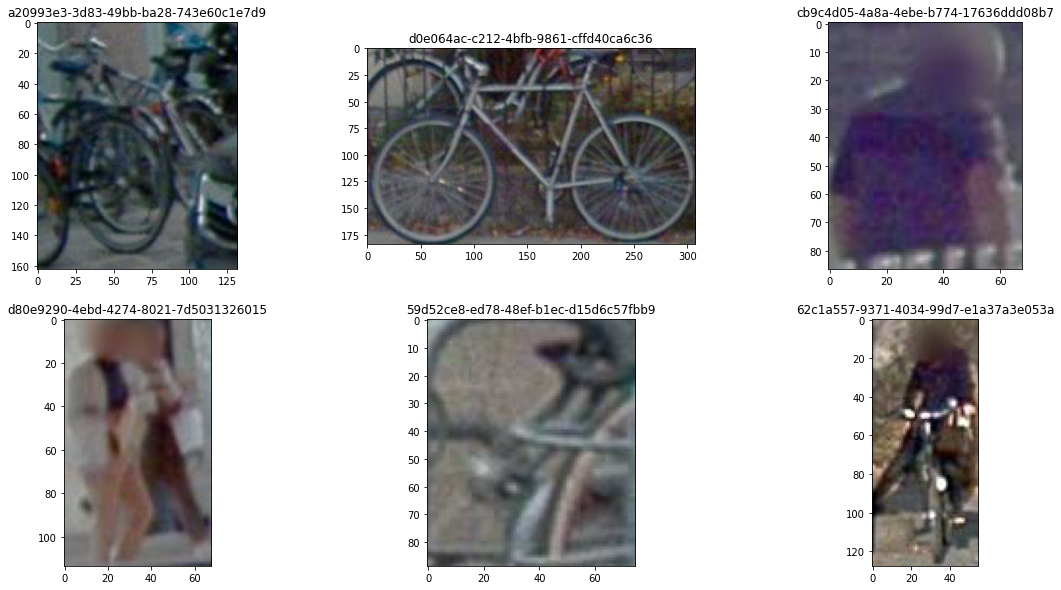

In [23]:
cant_solve_samples=df[(df['task_output.cant_solve'] == True)]['project_node_input_id'].unique()
fig=InputDisplay(projectparser).plot_images(cant_solve_samples[:6],2,3, figsize=(20,10))
fig.show()

Images flagged with "Corrupt_data"

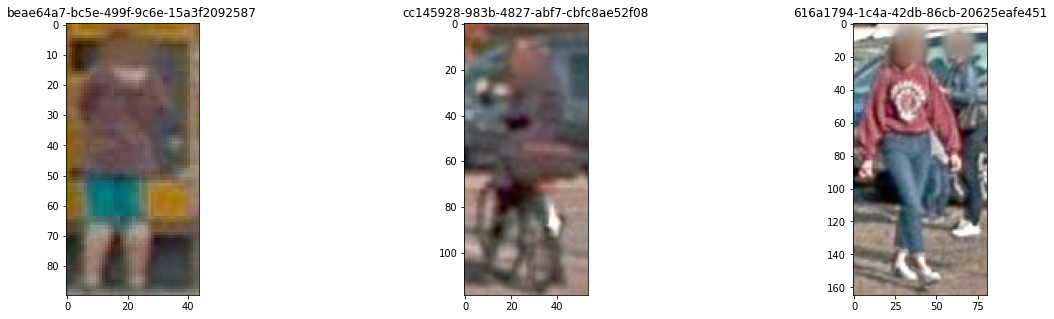

In [24]:
corrupt_data_samples=df[(df['task_output.corrupt_data'] == True)]['project_node_input_id'].unique()

fig=InputDisplay(projectparser).plot_images(corrupt_data_samples[:3],1,3, figsize=(20,5))
fig.show()

Not flagged images for comparison

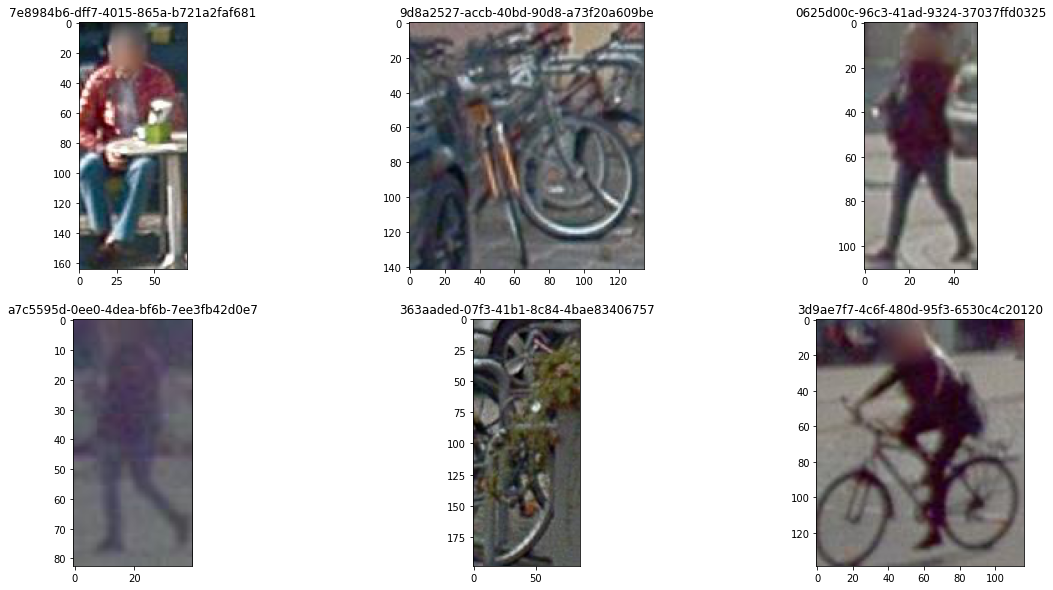

In [25]:
data_samples=df[(df['task_output.cant_solve'] == False) & (df['task_output.corrupt_data'] == False)]['project_node_input_id'].unique()

fig=InputDisplay(projectparser).plot_images(data_samples[:6],2,3, figsize=(20,10))
fig.show()

The images with the cant_solve and corrupt_data flag have no major differences to the "normal" data

A further investigation is shown below. 

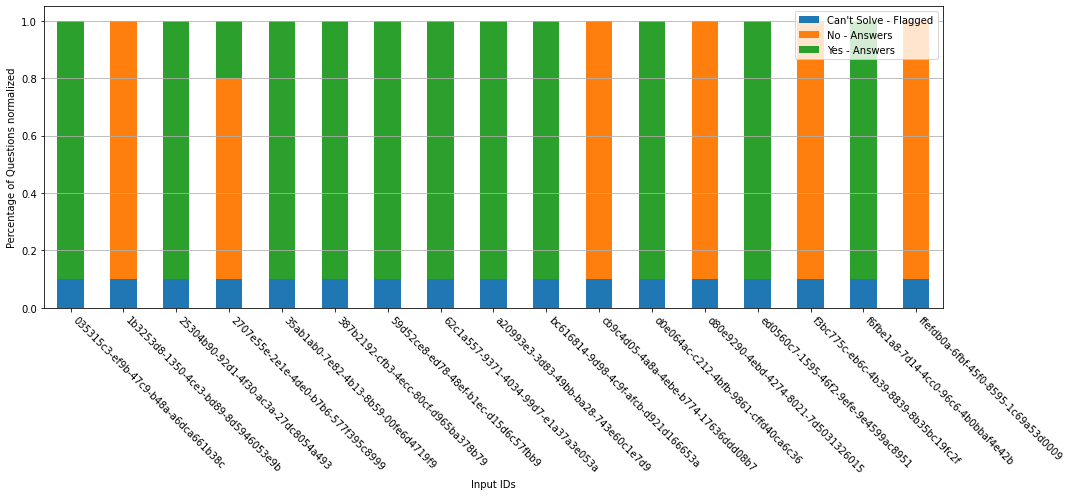

In [26]:
fig=plot_disagreement(df,cant_solve_samples,'Can\'t Solve', figsize=(15,7))
fig.tight_layout()
# fig.savefig('disagreement_cantsolve.png')
fig.show()

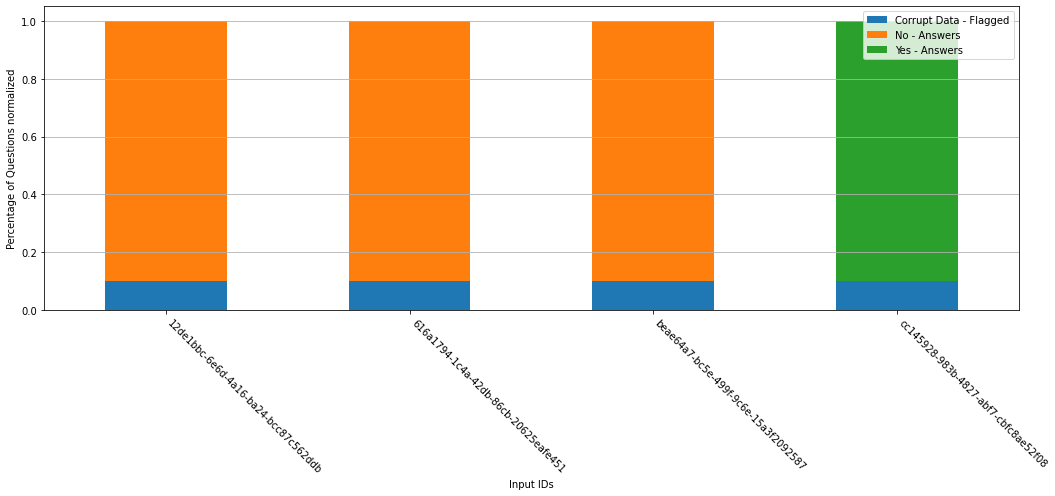

In [27]:
fig=plot_disagreement(df,corrupt_data_samples,'Corrupt Data',figsize=(15,7))
fig.tight_layout()
# fig.savefig('disagreement_corruptdata.png')
fig.show()

As seen in the statistics above, only one annotator has marked the input as cant_solve or corrupt_data (marked blue). This means, the input is only marked once by an annotator with the flag. This is very strange, because it would be assumed that an corrupted input or an not solvable input are marked more often as well as by different annotators. But this is not the case, which means that maybe the answers are marked unsolvable or corrupted by the annotators without a reason. 

## Task 3
### Is the reference set balanced?

In [28]:
project_image_names = df['task_input.image_url'].apply(extract_name_from_url).unique()
project_image_names.shape[0]

9087

In [29]:
references_image_names = df_ref['img_name'].unique()
references_image_names.shape[0]

9087

In [30]:
set(project_image_names)==set(references_image_names)

True

In [31]:
df_ref['is_bicycle'].value_counts()

True     4586
False    4501
Name: is_bicycle, dtype: int64

For every input in the project is a reference present. This is shown in the values above. The number of unique images names (extracted from url) in the project and the references are the same. That all images in the project has an reference allows to evaluate every output of all the annotators. 

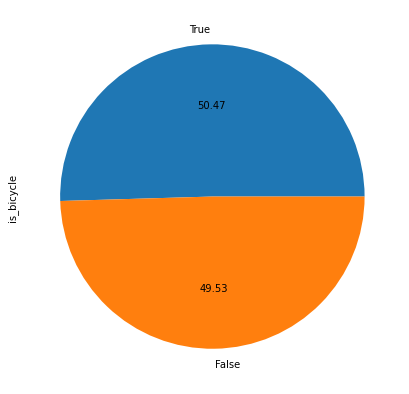

In [32]:
ax = df_ref['is_bicycle'].value_counts().plot.pie(figsize=(7,7),autopct='%.2f')
fig = ax.get_figure()
# fig.savefig('references_balanced.png')
fig.show()

Above is shown the balance of the references. As you can see, the distribution of yes and no is almost even, which indicates a balanced set of data, which is strengthened by the equal number of images in the project and in the references dataset.

## Task 4
### Using the reference set, can you identify good and bad annotators?

In [33]:
df['task_input.image_name'] = df['task_input.image_url'].apply(extract_name_from_url)

In [34]:
df_merge = df.merge(df_ref,left_on='task_input.image_name', right_on='img_name')

In [35]:
df_merge['task_output.answer.cleaned'] = df_merge['task_output.answer'].apply(convert_answer_to_bool)
df_merge['answer_correct'] = df_merge['task_output.answer.cleaned'] == df_merge['is_bicycle']

In [36]:
df_merge.head()

,created_at,workpackage_total_size,loss,project_node_input_id,project_node_output_id,project_root_node_input_id,task_input.image_url,task_output.answer,task_output.cant_solve,task_output.corrupt_data,task_output.duration_ms,user.vendor_id,user.id,user.vendor_user_id,root_input.image_url,task_input.image_name,img_name,is_bicycle,task_output.answer.cleaned,answer_correct
0,2021-02-25T14:08:11.319438+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,0000439a-96ac-4bd4-8753-a4baa229ecf2,7e8984b6-dff7-4015-865a-b721a2faf681,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,997,vendor_01,08af8775-a72c-4c59-b60f-9ce7df04fa92,annotator_12,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_4686,img_4686,False,False,True
1,2021-02-25T13:14:39.411149+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,0488b469-7c5f-459a-bfcb-ed94957c09c2,7e8984b6-dff7-4015-865a-b721a2faf681,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,845,vendor_01,62f1cf90-71c9-45c5-990c-f9dc0aa6ea3d,annotator_11,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_4686,img_4686,False,False,True
2,2021-02-25T15:19:57.889434+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,323902a9-3b41-4885-8796-4e393aa2e0a0,7e8984b6-dff7-4015-865a-b721a2faf681,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,1468,vendor_01,780c974e-6ce7-4f1d-9afe-56bf96753fca,annotator_22,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_4686,img_4686,False,False,True
3,2021-02-26T03:56:18.770331+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,4222ac20-7aaa-4b07-bb2b-4423bf41eefe,7e8984b6-dff7-4015-865a-b721a2faf681,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,1062,vendor_01,94afdf79-917c-4904-bdaa-7a121f33b0ff,annotator_17,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_4686,img_4686,False,False,True
4,2021-02-25T15:39:06.644705+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,42ba767f-5bd1-4e62-aff1-4e716fd23623,7e8984b6-dff7-4015-865a-b721a2faf681,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,879,vendor_01,37a6036c-a9ef-4fcb-b554-7058f00415db,annotator_02,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_4686,img_4686,False,False,True


In [37]:
df_annotators = df_merge.groupby(by='user.vendor_user_id')['answer_correct'].value_counts(normalize=True).mul(100).to_frame().rename(columns={'answer_correct':'answer_correct.percentage'})
df_annotators.head()

answer_correct.percentage
user.vendor_user_id answer_correct                           
annotator_01        True                            94.843750
                    False                            5.156250
annotator_02        True                            93.483412
                    False                            6.516588
annotator_03        True                            92.857143

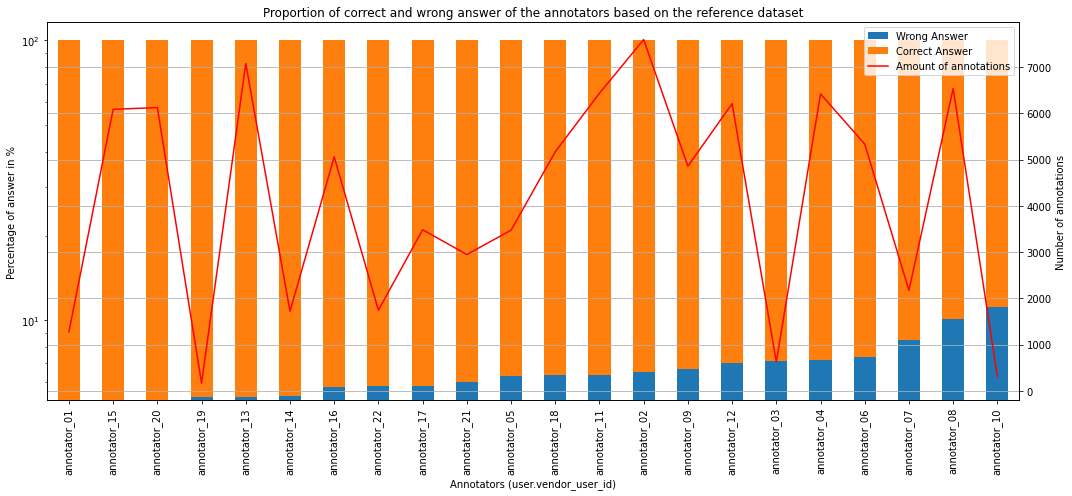

In [38]:
ax = df_annotators.unstack().sort_values(by=('answer_correct.percentage',True), ascending=False).plot.bar(stacked=True,logy=True, figsize=(15,7), ylabel="Percentage of answer in %", legend=False)
annotators_correct_answer_sorted_list = df_annotators.unstack().sort_values(by=('answer_correct.percentage',True), ascending=False).index.tolist()
ax2=df['user.vendor_user_id'].value_counts(sort=True).reindex(annotators_correct_answer_sorted_list).plot(ax=ax, rot=90, secondary_y=True,color='red',legend=False)

ax.set_xlabel("Annotators (user.vendor_user_id)")
ax2.set_ylabel("Number of annotations")
ax2.grid(axis='y')

label_mapping = {
    '(answer_correct.percentage, False)': 'Wrong Answer',
    '(answer_correct.percentage, True)': 'Correct Answer',
    'user.vendor_user_id (right)': 'Amount of annotations'
  }

ax2.legend(*zip(*map(lambda x, y: (x, label_mapping[y]), *merge_axis_legends(ax,ax2))), loc=0)
ax.set_title("Proportion of correct and wrong answer of the annotators based on the reference dataset")
fig=ax2.get_figure()
fig.tight_layout()
# fig.savefig('good_bad_annotators_comparision.png')
fig.show()

In [39]:
corr=pd.concat(
    [df['user.vendor_user_id'].value_counts(sort=True).reindex(annotators_correct_answer_sorted_list),
     df_annotators.unstack().sort_values(by=('answer_correct.percentage',True), ascending=False)],
     axis=1
)[['user.vendor_user_id',('answer_correct.percentage', False)]].rename(columns={'user.vendor_user_id':'Number of annotations',('answer_correct.percentage', False):'Wrong answer'}).corr()
corr.style.background_gradient(cmap='coolwarm')

/usr/local/lib/python3.7/dist-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


,Number of annotations,Wrong answer
Number of annotations,1.000000,-0.087797
Wrong answer,-0.087797,1.000000


In [40]:
df_annotators.reset_index()[df_annotators.reset_index()['answer_correct'] == False].describe()

,answer_correct.percentage
count,22.000000
mean,6.608538
std,1.561272
min,5.156250
25%,5.442403
50%,6.332897
75%,7.112376
max,11.111111


As seen above, there are small differences in the quality of annotations between the annotators. In average 6.6 % of the answers are not correct and do not correspond to the references. Annotator 1 has the lowest error rate with 5.16 % and Annotator 10 the highest with 11.11 %. 

Out of interest, we take a look at the correlation between the percentage of wrong answers and the amount of annotations to perhaps find a connection between few annotations and incorrect answers. 

Unfortunantly there is no correlation between these values, as you can see in the correlation matrix as well in Proportion graph. The only interesting datapoint is Annotator 10, which has the highest error rate and the second smallest amount of annotations, but this could be a occurred randomly. 